# Project 3: Quantum Dynamics
##    Eduardo Villaseñor - 
##    Eoin Horgan - 4582322

### Description:
A modelling of the time-dependent Schrödinger equation, taking m = 1, hbar = 1. 

In [1]:
%%latex
\begin{equation}
-i \frac{\partial\psi}{\partial t} = - \frac{\partial^2\psi}{\partial x^2} + V(x) \psi
= H \psi
\end{equation}

<IPython.core.display.Latex object>

The time evolution of the wave function is found using the Crank-Nicolson method:

In [2]:
%%latex
\begin{equation}
\psi^{n+1} = \frac{1-i\Delta t H_D/2}{1+i\Delta t H_D/2} \psi^n
\end{equation}

<IPython.core.display.Latex object>

### Prerequisites: Discrete Matrix Building and Plots

Run the next blocks before moving onto the demonstrations, below.

In [3]:
"""
simulation.py
Class that performs the evolution of the system.

created on: 24-04-2017.
@author: eduardo

"""
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import matrix


class Simulation:
    """
    This class handles the whole simulation of the quantum system.
    It takes a function for the potential and generates the discretised

    Hamiltonian. The evoluion of the system is made using Crank-Nicholson.
    """

    def __init__(self, dim, potentialFunc, dirichletBC, numberPoints,
                 startPoint, domainLength, dt):
        """Intilialize the object."""
        self.dim = dim
        self.numberPoints = numberPoints
        self.startPoint = startPoint
        self.domainLength = domainLength
        self.time = 0
        self.dt = dt

        self.sign = -1
        if dirichletBC:
            self.sign = 1

        self.allPoints = self.numberPoints + self.sign
        H = self._getHamiltonian(np.vectorize(potentialFunc))
        Id = sp.identity((self.numberPoints + self.sign)**self.dim)

        # Define the matrices used in CN evolution
        self.A = (Id + 1j*H*self.dt/2)
        self.B = (Id - 1j*H*self.dt/2)

        # Initialize wavefunction
        self.psi = np.zeros(self.allPoints**self.dim, dtype=np.complex128)

    def _getHamiltonian(self, potentialFunc):
        """
        Generate the Hamiltonian matrix using the functions
        defined in "matrix.py".
        """
        if self.dim == 1:
            if self.sign == -1:
                return matrix.A1D(self.numberPoints, potentialFunc,
                                  self.startPoint, self.domainLength)
            else:
                return matrix.A1Dfull(self.numberPoints, potentialFunc,
                                      self.startPoint, self.domainLength)

        if self.dim == 2:
            if self.sign == -1:
                return matrix.A2D(self.numberPoints, potentialFunc,
                                  self.startPoint, self.domainLength)
            else:
                return matrix.A2Dfull(self.numberPoints, potentialFunc,
                                      self.startPoint, self.domainLength)

    def setPsiPulse(self, pulse, energy, center, vel=1, width=.2):
        """
        Generate the initial wavefunction as a Gaussian wavepacket. By default
        it moves to the right.
        Inputs:
            pulse:  (string) plane wave or circular pulse
            energy: (int/float) The waves energy/size.
            center: (float or tuple) Either x or [x,y], for a guassian line
                    profile or 2D gaussian, respectively.
            vel:    (float or tuple) Velocity v_x or [v_x, v_y], the Velocity
                    of the pulse
            width:  Standard deviation of the Gaussian wave pulse.
        Output:
            Sets psi of the object to have the desired wave form.
        """
        if self.dim == 1:
            if pulse == "plane":
                x = np.linspace(self.startPoint,
                                self.startPoint + self.domainLength,
                                self.allPoints)
                self.pulse = np.exp(1j * vel * np.sqrt(energy) * x) * \
                                    np.exp(-0.5 * (x-center)**2 / width**2)
            else:
                self.pulse = np.zeros(self.allPoints)

        if self.dim == 2:
            x = np.linspace(self.startPoint[0],
                            self.startPoint[0] + self.domainLength,
                            self.allPoints)

            y = np.linspace(self.startPoint[1],
                            self.startPoint[1] + self.domainLength,
                            self.allPoints)

            if pulse == "plane":
                psix = np.exp(1j * vel * np.sqrt(energy) * x) * \
                              np.exp(-0.5 * (x-center)**2 / width**2)
                y = np.ones(self.allPoints)
                self.pulse = np.kron(psix, y)
            if pulse == "circular":
                psix = np.exp(1j * vel[0] * np.sqrt(energy) * x) * \
                              np.exp(-0.5 * (x-center[0])**2 / width**2)
                psiy = np.exp(1j * vel[1] * np.sqrt(energy) * y) * \
                              np.exp(-0.5 * (x-center[1])**2 / width**2)
                self.pulse = np.kron(psix, psiy)
            else:
                self.pulse = np.zeros(self.allPoints**2)

        self.psi += self.pulse/np.linalg.norm(self.pulse)

    def applyPulse(self):
        self.psi += self.pulse

    def normPsi(self):
        """Return the norm of the wave function."""
        return np.absolute(self.psi)**2

    def realPsi(self):
        """Return the real part of the wavefunction."""
        return np.real(self.psi)

    # Time evolutions
    def evolve(self):
        """Evolve the system using Crank-Nicholson."""
        self.time += self.dt
        self.psi = sp.linalg.spsolve(self.A, self.B.dot(self.psi),
                                     permc_spec='NATURAL')

    def evolvePulsed(self, freq):
        """Evolve the system using Crank-Nicholson."""
        self.time += 1
        if self.time % (freq) == 0:
            self.psi += self.pulse
            self.psi = self.psi/np.linalg.norm(self.psi)
        self.psi = sp.linalg.spsolve(self.A, self.B.dot(self.psi),
                                     permc_spec='NATURAL')

    def consistencyCheck(self):
        """Check if system is consisten by summing probabilities"""
        P = np.sum(self.normPsi())
        if abs(P-1) < .001:
            return True
        else:
            return False

In [4]:
#Matrix.py
import numpy as np
import scipy.sparse as sp


def A1D(numberPoints, potentialFunc, domainStart, domainLength):
    """
    Hamiltonian discretization in 1d without boundaries.

    Uses Explicit method.
    Input:
        Number of points to evaluate on (float)
        Potential function (vectorised function)
        Location where domain starts (float)
        Length of domain (float)
    Output:
        Matrix A (scipy sparse matrix)
    """
    h = domainLength/numberPoints   # dx

    x = np.linspace(domainStart, domainStart + domainLength, numberPoints-1)
    v = potentialFunc(x)

    a = np.ones(numberPoints-1)*(2+(h**2 * v))
    b = np.ones(numberPoints-2)*-1
    A = sp.diags(a, 0) + sp.diags(b, 1) + sp.diags(b, -1)

    # Periodic boundaries
    # A[0,-1] = -1
    # A[-1,0] = -1

    return (1./h**2) * A


def A1Dfull(numberPoints, potentialFunc, domainStart, domainLength):
    """
    Hamiltonian discretization in 1d with Dirichlet boundary conditions.

    Uses Explicit method to compute RHS of (A.68) in jos' book.
    Here we take hbar = 2m = 1.
    Input:
        Number of points to evaluate on (float)
        Potential function (vectorised function)
        Location where domain starts (float)
        Length of domain (float)
    Output:
        Matrix A, the discretised Hamiltonian (scipy sparse matrix)
    """
    h = domainLength/numberPoints  # dx

    x = np.linspace(domainStart, domainStart + domainLength, numberPoints+1)
    v = potentialFunc(x)

    a = np.ones(numberPoints+1)*(2+(h**2 * v))
    b = np.ones(numberPoints)*-1

    a[0] = h**2
    a[numberPoints] = h**2

    b[0] = 0
    b[numberPoints-1] = 0

    A = sp.diags(a, 0) + sp.diags(b, 1) + sp.diags(b, -1)
    return (1./h**2) * A


def A2D(numberPoints, potentialFunc, domainStart, domainLength):
    """
    Hamiltonian discretization in 2d without boundaries.

    Here we take hbar = 2m = 1.
    Input:
        Number of points to evaluate in each axis direction (float)
        Potential function (vectorised function)
        Location where domain starts (tuple)
        Length of domain (float)
    Output:
        Matrix A, the discretised Hamiltonian (scipy sparse matrix)
    """
    h = domainLength/numberPoints  # dx

    o = np.ones(numberPoints-1)
    x = np.linspace(domainStart[0], domainStart[0] + domainLength,
                    numberPoints-1)
    y = np.linspace(domainStart[1], domainStart[1] + domainLength,
                    numberPoints-1)
    x = np.kron(x, o)
    y = np.kron(o, y)
    v = potentialFunc(x, y)

    a = np.ones(numberPoints-1)*(2)
    b = np.ones(numberPoints-2)*(-1)

    Id = np.identity(numberPoints-1)

    A1d = sp.diags(a, 0) + sp.diags(b, 1) + sp.diags(b, -1)
    A = sp.kron(Id, A1d) + sp.kron(A1d, Id) + h**2 * sp.diags(v, 0)
    return (1./h**2) * A


def _Ih(numberPoints):
    """Return Identity matrix of given length with zeros on the extremes."""
    Id = np.ones(numberPoints+1)
    Id[0] = 0
    Id[numberPoints] = 0
    return sp.diags(Id)


def _Th(numberPoints, potentialFunc, domainStart, domainLength):
    """Create a section of the matrix A."""
    h = domainLength/numberPoints

    o = np.ones(numberPoints+1)
    x = np.linspace(domainStart[0], domainStart[0] + domainLength,
                    numberPoints+1)
    y = np.linspace(domainStart[1], domainStart[1] + domainLength,
                    numberPoints+1)
    x = np.kron(x, o)
    y = np.kron(o, y)
    v = potentialFunc(x, y)
    a = np.ones(numberPoints+1)*(4. + h**2 * v)
    b = np.ones(numberPoints)*(-1)

    a[0] = h**2
    a[numberPoints] = h**2

    b[0] = 0
    b[numberPoints-1] = 0

    T = sp.diags(a, 0) + sp.diags(b, -1) + sp.diags(b, 1)
    return T


def A2Dfull(numberPoints, potentialFunc, domainStart, domainLength):
    """Hamiltonian discretization in 2D with dirichlet boundary conditions."""
    h = domainLength/numberPoints
    a = np.ones(numberPoints+1)
    b = np.ones(numberPoints)*(-1)
    b2 = np.zeros(numberPoints+1)
    a[0] = 0
    a[numberPoints] = 0
    b[0] = 0
    b[numberPoints-1] = 0
    b2[0] = 1
    b2[numberPoints] = 1

    Center1 = sp.diags(a, 0)
    Center2 = sp.diags(b, 1)
    Center3 = sp.diags(b, -1)
    Bounds = sp.diags(b2, 0)

    T = _Th(numberPoints, potentialFunc, domainStart, domainLength)
    Id = _Ih(numberPoints)
    I_N = (h**2)*sp.identity(numberPoints+1)

    A = sp.kron(Center1, T) + sp.kron(Center2, Id) + sp.kron(Center3, Id) \
      + sp.kron(Bounds, I_N)
    return (1./h**2)*A


In [5]:
# quantum_plots.py
# -*- coding: utf-8 -*-
"""
Hold all the methods for plotting and saving animations.

Created on Tue Apr 25 00:38:00 2017
@author: Eoin
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os.path


def OneD_animation(sim, x, V='none', psi='real', save=False):
    """
    Make an animation of a 1D system.

    Inputs:
        sim: (simulation object) An object of the simulation class.
        x: (N, numpy vector) x-coordinates of the domain.
        V: (vectorised function) The potential function, or "none", to
            indicate it should not be plotted.
        psi: (string) "real" or "norm" to determine whether to plot
            Re(Ψ) or |Ψ|^2
        save: (Boolean) Whether the animation should be saved.
    Outputs:
        Displays animation with both the evolving wavefunction norm and the
            potential function influencing it.
    """
    # Animation stuff
    fig, ax1 = plt.subplots()
    if psi == 'real':
        ax1.set_ylabel('$Re(\psi(x))$')
        line, = ax1.plot(x, sim.realPsi())
    else:
        ax1.set_ylabel('$|\psi(x)|^2$')
        line, = ax1.plot(x, sim.normPsi())
    ax1.tick_params('y', colors='b')
    ax1.set_xlabel('x')

    def animate(i):
        sim.evolve()
        if psi == 'real':
            line.set_ydata(sim.realPsi())
        else:
            line.set_ydata(sim.normPsi())
        return line,

    ani = animation.FuncAnimation(fig, animate, frames=600, interval=10)

    if V != 'none':
        ax2 = ax1.twinx()
        ax2.plot(x, V(x), 'r')
        ax2.set_ylabel('$V(x)$')
        ax2.tick_params('y', colors='r')

    plt.show()

    if save:
        _ani_save(ani, sim)

    return ani


def TwoD_sc(sim, domain, allPoints, potentialFunc, psi="norm", save=False):
    """
    Make a 2D animation of a 2D system.

    Inputs:
        sim: (simulation object) An object of the simulation class.
        psi: (string) "real" or "norm" to determine whether to plot
            Re(Ψ) or |Ψ|^2
        allPoints:
        save: (Boolean) Whether the animation should be saved.
    Outputs:
        Displays animation with both the evolving wavefunction norm and the
            potential function influencing it.
    """
    pot_data = np.vectorize(potentialFunc)(domain[0], domain[1])

    fig = plt.figure()
    im = plt.imshow(np.transpose(sim.normPsi().reshape(allPoints, allPoints)),
                    animated=True, cmap=plt.get_cmap('jet'), alpha=.9,
                    origin='lower')
    plt.imshow(pot_data, cmap=plt.get_cmap('Greys'), alpha=1, origin='lower')

    def animate(i):
        sim.evolve()
        if psi == "norm":
            im.set_array(np.transpose(sim.normPsi().reshape(allPoints,
                         allPoints)))
        else:
            im.set_array(np.transpose(sim.realPsi().reshape(allPoints,
                         allPoints)))

        return im,

    ani = animation.FuncAnimation(fig, animate, frames=600,
                                  interval=10, blit=True)

    plt.show()

    if save:
        _ani_save(ani, sim)

    return ani


def _ani_save(ani, sim):
    """
    Save animation to file. Requires installation of ffmpeg.

    Warning: Because this is a continous animation, instead of a fixed length
    one, this will cause the animation to not be displayed and saved instead.
    Need to close the figure window in order to allow it to finish.
    TODO : Fix it so that this is less hacky and doesn't cause the kernel to
    crash.
    Inputs:
        ani: (matplotlib animation object) The animation to be saved.
        sim: (simulation object) An object of the simulation class.
    Outputs:
        A movie, saved in .mp4 format to a subfolder.
    """
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=60,
                    metadata=dict(artist='Eduardo Villaseñor & Eoin Horgan'),
                    bitrate=3000)

    # Make folder if it doesn't already exist
    if not os.path.exists('Saved Animations'):
        os.makedirs('Saved Animations')

    if sim.sign == 1:
        dBC = 'yes'
    else:
        dBC = 'no'

    filepath = os.path.join("Saved Animations",
                            "D = " + str(sim.dim) +
                            ", n = " + str(sim.numberPoints) +
                            ", L = " + str(sim.domainLength) +
                            ", dBC = " + dBC +
                            ", dt = " + str(sim.dt) + '.mp4')
    ani.save(filepath, writer=writer)


In [6]:
# Make animations work with IPython
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

## 1D Simulations:
### Potential Well

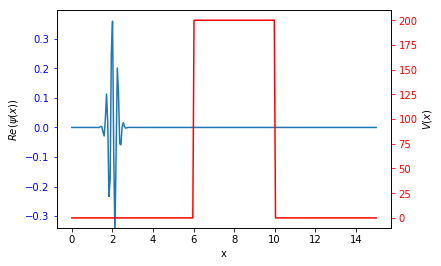

In [10]:
"""
potentilWell.py
A simple animation for the 1D case
with potential well.

Created on: 24-04-2017.
@author: eduardo
"""
import quantum_plots as qplots

import numpy as np
import simulation as sm


# Define the system parameters
dim = 1
numberPoints = 256
dt = .001
dirichletBC = False
startPoint = 0
domainLength = 15

sign = -1
if dirichletBC:
    sign = 1

x = np.linspace(startPoint, startPoint + domainLength, numberPoints + sign)


def potentialWell(x):
    mag = 200
    domain = [6, 10]
    if domain[0] < x < domain[1]:
        return mag
    else:
        return 0


potentialFunc = np.vectorize(potentialWell)


# Create the simulation for the system
sim = sm.Simulation(dim=dim, potentialFunc=potentialFunc,
                    dirichletBC=dirichletBC, numberPoints=numberPoints,
                    startPoint=startPoint, domainLength=domainLength,
                    dt=dt)

# Create the initial wave function
sim.setPsiPulse(pulse="plane", energy=500, center=2)
# plt.plot(x, sim.realPsi())
# plt.show()


ani = qplots.animation1D(sim, x, psi='real', V=potentialFunc)


In [11]:
HTML(ani.to_html5_video())